In [1]:
from typing import List

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
import sys
from actlearn.select import kriging_believer, predict_posterior

In [1]:
from rdkit.Chem.MolStandardize import rdMolStandardize

params = rdMolStandardize.CleanupParameters()
params.maxTautomers = 100
params.maxTransforms = 100
te = rdMolStandardize.TautomerEnumerator(params)


def inchi_to_smiles(inchi):
    if not inchi:
        return None
    mol = Chem.MolFromInchi(inchi)
    if not mol:
        return None
    return Chem.MolToSmiles(te.Canonicalize(mol))


def add_inchikeys(inrep):
    if type(inrep) == str:
        mol = Chem.MolFromSmiles(inrep)
    else:
        mol = inrep
    try:
        inchikey = inchi.MolToInchiKey(mol, options="/FixedH")
    except:
        inchikey = None
    return inchikey

In [2]:
def rxn_dfp(rsmi):
    r, _, p = rsmi.split('>')
    rfp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(r), 4, useChirality=True)
    pfp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(p), 4, useChirality=True)
    return np.array(pfp) - np.array(rfp)

In [3]:
domain = pd.read_csv("../data/brbr_reaction_domain.csv")
domain.columns

NameError: name 'pd' is not defined

In [6]:
domain

,smiles,smiles_alkyl,smiles_aryl,reaction_smarts,CAD Percent Yield (%),selection,category
0,CC(C)(C)OC(=O)N1CCC(COc2ccc(CCN(C3OC(=O)c4cccc...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN
1,CC(C)(C)OC(=O)N1CCN(c2ccc(CCN(C3OC(=O)c4ccccc4...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CC(C)(C)OC(=O)N1CCN(c2ccc(Br)cc2Cl)CC1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN
2,CCOC(=O)C(=O)CC(=O)c1ccc(CCN(C2OC(=O)c3ccccc32...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN
3,O=C1OC(N(CCc2ccc(S(=O)(=O)N3CCSCC3)cc2)C2OC(=O...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN
4,CS(=O)(=O)N(c1ccc(CCN(C2OC(=O)c3ccccc32)C2OC(=...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN
...,...,...,...,...,...,...,...
22203,Cc1ccc(S(=O)(=O)N2CCSCC2)cc1,CBr,O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,CBr.O=S(=O)(c1ccc(Br)cc1)N1CCSCC1>>Cc1ccc(S(=O...,NaN,NaN,NaN
22204,Cc1ccc(N(S(C)(=O)=O)S(C)(=O)=O)cc1,CBr,CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,CBr.CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O>>Cc1cc...,NaN,NaN,NaN
22205,Cc1cccc(-c2c(C)cccc2F)c1,CBr,Cc1cccc(-c2c(F)cccc2Br)c1,CBr.Cc1cccc(-c2c(F)cccc2Br)c1>>Cc1cccc(-c2c(C)...,NaN,NaN,NaN
22206,COC(=O)c1cc(C)ccc1OC(F)F,CBr,COC(=O)c1cc(Br)ccc1OC(F)F,CBr.COC(=O)c1cc(Br)ccc1OC(F)F>>COC(=O)c1cc(C)c...,NaN,NaN,NaN


In [7]:
# make sure product smiels in domain are canonical
domain['smiles'] = domain['smiles'].apply(lambda x: Chem.CanonSmiles(x, False))
domain['smiles_alkyl'] = domain['smiles_alkyl'].apply(lambda x: Chem.CanonSmiles(x, False))
domain['smiles_aryl'] = domain['smiles_aryl'].apply(lambda x: Chem.CanonSmiles(x, False))
# create reaction smiles
domain['rsmi'] = domain.apply(lambda x: f'{x.smiles_alkyl}.{x.smiles_aryl}>>{x["smiles"]}', axis=1)

In [8]:
# selection and data from previous iteration and add to domain (this is batch 3, so we have initial_diverse, active_learning_1 & 2 so far)
# note that 16 molecules are selected, only 12 are ordered, and data may come back for only 10-11 molecules if one present practical challenges
# if a molecule is ordered but not tested, we want to make sure not to suggest it again.
# the other 4 in the batch are fair game to suggest again by current rules (although if Lucas can't order one we should remove it)
# we shouldn't remove a molecule if Lucas just didn't get to it in the order

df_exp2 = pd.read_excel("../data/batch3_raw_data.xlsx", index_col=0)
df_exp2.head(5)

,index,productId,mw,em,INCHI,theoMass,theoMol,index.1,Raw CAD Areas,log (CAD Area),...,CAD [sample](mg),Raw UV Areas,log (UV Area),UV log([sample])(mg/ml),UV [sample](mg/ml),UV [sample](mg),CAD Reaction Yield (mg),CAD Percent Yield (%),UV Reaction Yield (mg),UV Percent Yield (%)
0,chemicalDrawing:cd96944f-1599-4212-9b16-99796d...,SOUZALUH-100-EXP017-1-P1,393.42 g/mol,393.10103,InChI=1S/C20H18F3NO2S/c1-14-24-17(12-27-14)16-...,12.85,32.67 μmol,0,1.939904e+01,1.287780,...,0.157394,2.538493e+06,6.404576,-3.767658e-01,0.419985,0.091347,15.739387,122.485505,9.134683,71.087026
1,chemicalDrawing:0ca6d47b-aaa8-4d01-8c20-374201...,SOUZALUH-100-EXP017-2-P1,438.40 g/mol,438.12902,InChI=1S/C22H21F3O6/c1-2-29-21(28)18(27)13-17(...,14.32,32.67 μmol,1,1.000000e-12,-12.000000,...,0.217500,1.000000e-12,-12.000000,-1.200000e-10,1.000000,0.217500,21.750000,0.000000,0.000000,0.000000
2,chemicalDrawing:2927df69-842c-4d0c-911d-61c57a...,SOUZALUH-100-EXP017-3-P1,509.57 g/mol,509.23891,"InChI=1S/C27H34F3NO5/c1-26(2,3)36-25(32)31-15-...",16.65,32.67 μmol,2,1.416119e+01,1.151100,...,0.075372,5.967022e+05,5.775758,-6.431429e-01,0.227435,0.049467,7.537184,45.268372,4.946709,29.709962
3,chemicalDrawing:91cb2d73-5bf5-4f8c-a472-11bff3...,SOUZALUH-100-EXP017-4-P1,467.47 g/mol,467.06841,"InChI=1S/C18H20F3NO6S2/c1-29(23,24)22(30(2,25)...",15.27,32.67 μmol,3,1.142152e+01,1.057724,...,0.157456,7.012190e+05,5.845854,-5.853231e-01,0.259823,0.056511,15.745624,103.114759,5.651141,37.008126
4,chemicalDrawing:7b15e235-c130-4493-af78-736b1d...,SOUZALUH-100-EXP017-5-P1,404.40 g/mol,404.13994,InChI=1S/C23H20F4O2/c1-16-6-4-8-18(14-16)22-17...,13.21,32.67 μmol,4,8.049450e+00,0.905766,...,0.036920,7.067656e+05,5.849275,-7.392171e-01,0.182298,0.039650,3.692015,27.948636,3.964991,30.015071


In [9]:
# convert INCHI to smiles. These should be the product smiles, which can be matched back to domain for merging
df_exp2["mol"] = df_exp2["INCHI"].apply(Chem.inchi.MolFromInchi)
df_exp2["smiles"] = df_exp2["mol"].apply(Chem.MolToSmiles, canonical=True)

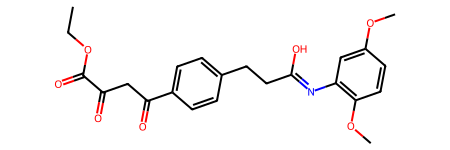

In [10]:
enol_9 = df_exp2["mol"].loc[9]
enol_9

In [11]:
de_enol = AllChem.ReactionFromSmarts("[N:1]=[#6:2][OH:3]>>[N:1]-[#6:2]=[O!H0:3]")
denol_9 = de_enol.RunReactants([enol_9])
#denol_9 = denol_9[0][0]
denol_9

((<rdkit.Chem.rdchem.Mol at 0x7f2ea9f889e0>,),)

In [12]:
df_exp2['smiles_canon'] = df_exp2['smiles'].apply(lambda x: Chem.CanonSmiles(x, False))

In [13]:
df_exp2_enol = df_exp2[~df_exp2["smiles_canon"].isin(domain["smiles"])]
df_exp2_enol["mol_denol"] = df_exp2_enol["mol"].apply(lambda x: de_enol.RunReactants([x])[0][0])

/tmp/ipykernel_48743/3353780438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp2_enol["mol_denol"] = df_exp2_enol["mol"].apply(lambda x: de_enol.RunReactants([x])[0][0])


In [14]:
df_exp2_enol["smiles_canon"] = df_exp2_enol["mol_denol"].apply(Chem.MolToSmiles)
df_exp2_enol["smiles_canon"].isin(domain["smiles"]).value_counts()

/tmp/ipykernel_48743/1030974283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp2_enol["smiles_canon"] = df_exp2_enol["mol_denol"].apply(Chem.MolToSmiles)


smiles_canon
True    24
Name: count, dtype: int64

In [15]:
df_exp2_match = df_exp2[df_exp2["smiles_canon"].isin(domain["smiles"])]
df_exp2_cat = pd.concat([df_exp2_match, df_exp2_enol])
print(df_exp2_cat.shape, df_exp2.shape)

(96, 26) (96, 25)


In [16]:
print(len(df_exp2_cat["smiles_canon"].unique()))

96


In [17]:
df_exp2_cat["selection"] = "active_learning_2"

In [18]:
domain_index = domain.set_index("smiles")
df_exp2_cat["smiles"] = df_exp2_cat["smiles_canon"]
df_exp2_index = df_exp2_cat.set_index("smiles")

In [19]:
domain_index.update(df_exp2_index[["selection", "CAD Percent Yield (%)"]])

In [20]:
domain_index["selection"].value_counts()

selection
active_learning_2    96
active_learning_1    96
initial_diverse      88
Name: count, dtype: int64

In [21]:
domain_index[domain_index["selection"] == "active_learning_2"]

,smiles_alkyl,smiles_aryl,reaction_smarts,CAD Percent Yield (%),selection,category,rsmi
smiles,,,,,,,
CC(C)(C)OC(=O)N1CCC(COc2ccc(CCCCCCn3c4ccccc4c4ccccc43)cc2)CC1,BrCCCCCCn1c2ccccc2c2ccccc21,CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,BrCCCCCCn1c2ccccc2c2ccccc21.CC(C)(C)OC(=O)N1CC...,24.409734,active_learning_2,NaN,BrCCCCCCn1c2ccccc2c2ccccc21.CC(C)(C)OC(=O)N1CC...
CC(C)(C)OC(=O)N1CCN(c2ccc(CCCCCCn3c4ccccc4c4ccccc43)cc2Cl)CC1,BrCCCCCCn1c2ccccc2c2ccccc21,CC(C)(C)OC(=O)N1CCN(c2ccc(Br)cc2Cl)CC1,BrCCCCCCn1c2ccccc2c2ccccc21.CC(C)(C)OC(=O)N1CC...,37.142245,active_learning_2,NaN,BrCCCCCCn1c2ccccc2c2ccccc21.CC(C)(C)OC(=O)N1CC...
CCOC(=O)C(=O)CC(=O)c1ccc(CCCCCCn2c3ccccc3c3ccccc32)cc1,BrCCCCCCn1c2ccccc2c2ccccc21,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,BrCCCCCCn1c2ccccc2c2ccccc21.CCOC(=O)C(=O)CC(=O...,0.0,active_learning_2,NaN,BrCCCCCCn1c2ccccc2c2ccccc21.CCOC(=O)C(=O)CC(=O...
O=S(=O)(c1ccc(CCCCCCn2c3ccccc3c3ccccc32)cc1)N1CCSCC1,BrCCCCCCn1c2ccccc2c2ccccc21,O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,BrCCCCCCn1c2ccccc2c2ccccc21.O=S(=O)(c1ccc(Br)c...,50.97852,active_learning_2,NaN,BrCCCCCCn1c2ccccc2c2ccccc21.O=S(=O)(c1ccc(Br)c...
CS(=O)(=O)N(c1ccc(CCCCCCn2c3ccccc3c3ccccc32)cc1)S(C)(=O)=O,BrCCCCCCn1c2ccccc2c2ccccc21,CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,BrCCCCCCn1c2ccccc2c2ccccc21.CS(=O)(=O)N(c1ccc(...,95.811273,active_learning_2,NaN,BrCCCCCCn1c2ccccc2c2ccccc21.CS(=O)(=O)N(c1ccc(...
...,...,...,...,...,...,...,...
O=C1CC(Cc2ccc(S(=O)(=O)N3CCSCC3)cc2)CN1,O=C1CC(CBr)CN1,O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,O=C1C[C@@H](CBr)CN1.O=S(=O)(c1ccc(Br)cc1)N1CCS...,28.863911,active_learning_2,NaN,O=C1CC(CBr)CN1.O=S(=O)(c1ccc(Br)cc1)N1CCSCC1>>...
CS(=O)(=O)N(c1ccc(CC2CNC(=O)C2)cc1)S(C)(=O)=O,O=C1CC(CBr)CN1,CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,O=C1C[C@@H](CBr)CN1.CS(=O)(=O)N(c1ccc(Br)cc1)S...,26.974603,active_learning_2,NaN,O=C1CC(CBr)CN1.CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=...
Cc1cccc(-c2c(F)cccc2CC2CNC(=O)C2)c1,O=C1CC(CBr)CN1,Cc1cccc(-c2c(F)cccc2Br)c1,O=C1C[C@@H](CBr)CN1.Cc1cccc(-c2c(F)cccc2Br)c1>...,32.289554,active_learning_2,NaN,O=C1CC(CBr)CN1.Cc1cccc(-c2c(F)cccc2Br)c1>>Cc1c...


In [22]:
print(domain_index[~domain_index["CAD Percent Yield (%)"].isna()].shape)
print(domain[~domain["CAD Percent Yield (%)"].isna()].shape)
domain = domain_index
domain.reset_index(inplace=True)
domain.head(5)

(262, 7)
(166, 8)


,smiles,smiles_alkyl,smiles_aryl,reaction_smarts,CAD Percent Yield (%),selection,category,rsmi
0,CC(C)(C)OC(=O)N1CCC(COc2ccc(CCN(C3OC(=O)c4cccc...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.CC(C...
1,CC(C)(C)OC(=O)N1CCN(c2ccc(CCN(C3OC(=O)c4ccccc4...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CC(C)(C)OC(=O)N1CCN(c2ccc(Br)cc2Cl)CC1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.CC(C...
2,CCOC(=O)C(=O)CC(=O)c1ccc(CCN(C2OC(=O)c3ccccc32...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.CCOC...
3,O=C1OC(N(CCc2ccc(S(=O)(=O)N3CCSCC3)cc2)C2OC(=O...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.O=S(...
4,CS(=O)(=O)N(c1ccc(CCN(C2OC(=O)c3ccccc32)C2OC(=...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.CS(=...


In [23]:
domain

,smiles,smiles_alkyl,smiles_aryl,reaction_smarts,CAD Percent Yield (%),selection,category,rsmi
0,CC(C)(C)OC(=O)N1CCC(COc2ccc(CCN(C3OC(=O)c4cccc...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.CC(C...
1,CC(C)(C)OC(=O)N1CCN(c2ccc(CCN(C3OC(=O)c4ccccc4...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CC(C)(C)OC(=O)N1CCN(c2ccc(Br)cc2Cl)CC1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.CC(C...
2,CCOC(=O)C(=O)CC(=O)c1ccc(CCN(C2OC(=O)c3ccccc32...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.CCOC...
3,O=C1OC(N(CCc2ccc(S(=O)(=O)N3CCSCC3)cc2)C2OC(=O...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.O=S(...
4,CS(=O)(=O)N(c1ccc(CCN(C2OC(=O)c3ccccc32)C2OC(=...,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21,CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,O=C1O[C@@H](N(CCBr)[C@@H]2OC(=O)c3ccccc32)c2cc...,NaN,NaN,NaN,O=C1OC(N(CCBr)C2OC(=O)c3ccccc32)c2ccccc21.CS(=...
...,...,...,...,...,...,...,...,...
22203,Cc1ccc(S(=O)(=O)N2CCSCC2)cc1,CBr,O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,CBr.O=S(=O)(c1ccc(Br)cc1)N1CCSCC1>>Cc1ccc(S(=O...,NaN,NaN,NaN,CBr.O=S(=O)(c1ccc(Br)cc1)N1CCSCC1>>Cc1ccc(S(=O...
22204,Cc1ccc(N(S(C)(=O)=O)S(C)(=O)=O)cc1,CBr,CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,CBr.CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O>>Cc1cc...,NaN,NaN,NaN,CBr.CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O>>Cc1cc...
22205,Cc1cccc(-c2c(C)cccc2F)c1,CBr,Cc1cccc(-c2c(F)cccc2Br)c1,CBr.Cc1cccc(-c2c(F)cccc2Br)c1>>Cc1cccc(-c2c(C)...,NaN,NaN,NaN,CBr.Cc1cccc(-c2c(F)cccc2Br)c1>>Cc1cccc(-c2c(C)...
22206,COC(=O)c1cc(C)ccc1OC(F)F,CBr,COC(=O)c1cc(Br)ccc1OC(F)F,CBr.COC(=O)c1cc(Br)ccc1OC(F)F>>COC(=O)c1cc(C)c...,NaN,NaN,NaN,CBr.COC(=O)c1cc(Br)ccc1OC(F)F>>COC(=O)c1cc(C)c...


In [24]:
# load DFT features
alkyl = pd.read_csv('../data/BrBr_dft_selectfeatures_alkylBr.csv')
aryl = pd.read_csv('../data/BrBr_dft_selectfeatures_arylBr.csv')
alkyl['smiles'] = alkyl['smiles'].apply(lambda x: Chem.CanonSmiles(x, False))
aryl['core_smiles'] = aryl['core_smiles'].apply(lambda x: Chem.CanonSmiles(x, False))
alkyl = alkyl.groupby('smiles').mean(numeric_only=True)
aryl = aryl.groupby('core_smiles').mean(numeric_only=True)

In [25]:
# add features to domain
domain_dfp = np.vstack(joblib.Parallel(n_jobs=32, verbose=1)(
    joblib.delayed(rxn_dfp)(rsmi) for rsmi in domain['reaction_smarts']
))
domain_core_f = aryl.loc[domain['smiles_aryl']].values
domain_bb_f = alkyl.loc[domain['smiles_alkyl']].values
# merging alkyl and aryl DFT features with reaction fingerprints
domain_f = np.hstack([domain_dfp, domain_core_f, domain_bb_f])
f_cols = [f'f_{idx}' for idx in range(domain_f.shape[1])]
# adding features to domain
domain.loc[:, f_cols] = domain_f

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   36.0s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:   37.1s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:   38.7s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:   40.9s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:   43.4s
[Parallel(n_jobs=32)]: Done 2788 tasks      | elapsed:   46.2s
[Parallel(n_jobs=32)]: Done 4288 tasks      | elapsed:   49.8s
[Parallel(n_jobs=32)]: Done 5988 tasks      | elapsed:   53.6s
[Parallel(n_jobs=32)]: Done 21056 tasks      | elapsed:   58.9s
[Parallel(n_jobs=32)]: Done 22208 out of 22208 | elapsed:  1.0min finished


In [26]:
task_name = "CAD Percent Yield (%)"
print(domain.shape)
results = domain[(domain[task_name] != 'no signal') & (domain[task_name] != 'INCONCLUSIVE') & (domain[task_name] != 'co eluted')].dropna(subset=[task_name])
print(results.shape)

(22208, 2143)
(257, 2143)


In [27]:
results = results.reset_index(drop=True)
results[task_name] = pd.to_numeric(results[task_name], errors="coerce")
results.dropna(subset=task_name, inplace=True)
print(results.shape)

(255, 2143)


In [28]:
# remove anything reserved for test set or already submitted for testing (including example with no data)
domain = domain[(domain["category"] != "test") & (domain["selection"].isna())]

In [29]:
experiments = kriging_believer(
    domain=domain,
    results=results,
    x_cols=f_cols,
    batch_size=20,
    id_column='smiles',
    target_column=task_name,
    bb_smiles_column='smiles_alkyl',
    output_dir='iterations/batch_3'
)

  0%|          | 0/20 [00:00<?, ?it/s]/home/rickena1/modules/mcds-actlearn/actlearn/utils.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df1, df2, df2]).drop_duplicates(subset = columns, keep = False)
  5%|▌         | 1/20 [00:04<01:23,  4.38s/it]/home/rickena1/modules/mcds-actlearn/actlearn/utils.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df1, df2, df2]).drop_duplicates(subset = columns, keep = False)
 10%|█         | 2/20 [00:08<01:15,  4.19s

In [30]:
from rdkit.Chem import PandasTools

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [31]:
df = PandasTools.LoadSDF('iterations/batch_3/selections.sdf')

Failed to patch pandas - unable to change molecule rendering


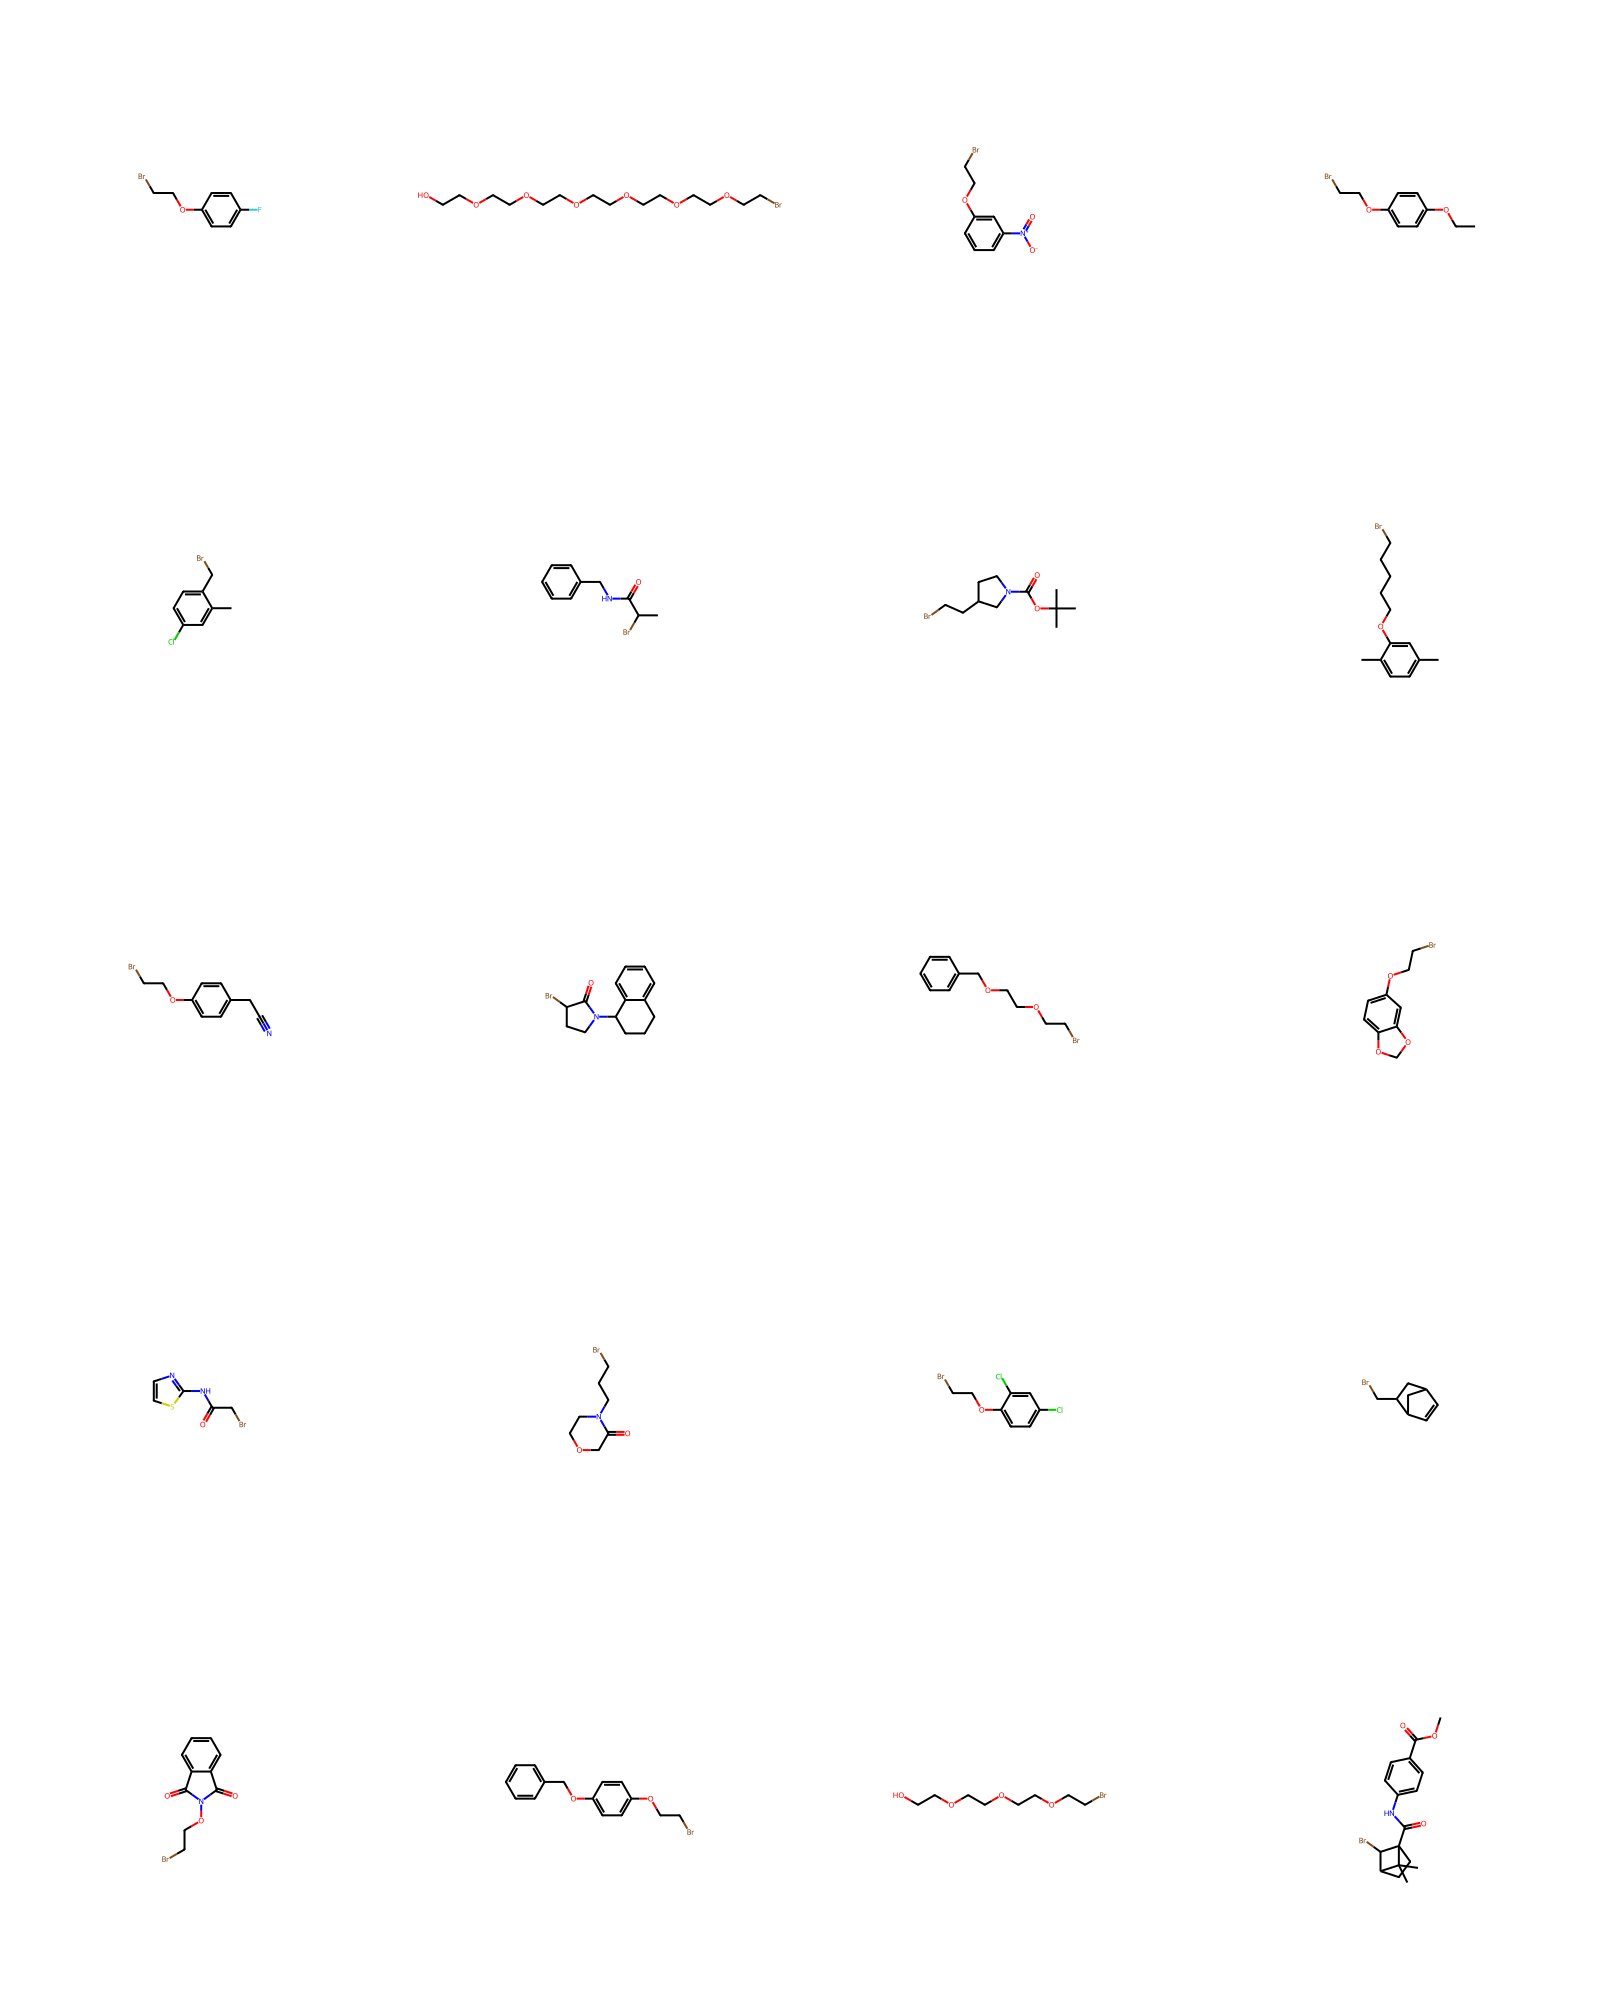

In [32]:
Chem.Draw.MolsToGridImage(df["ROMol"], subImgSize=(400,400), molsPerRow=4)

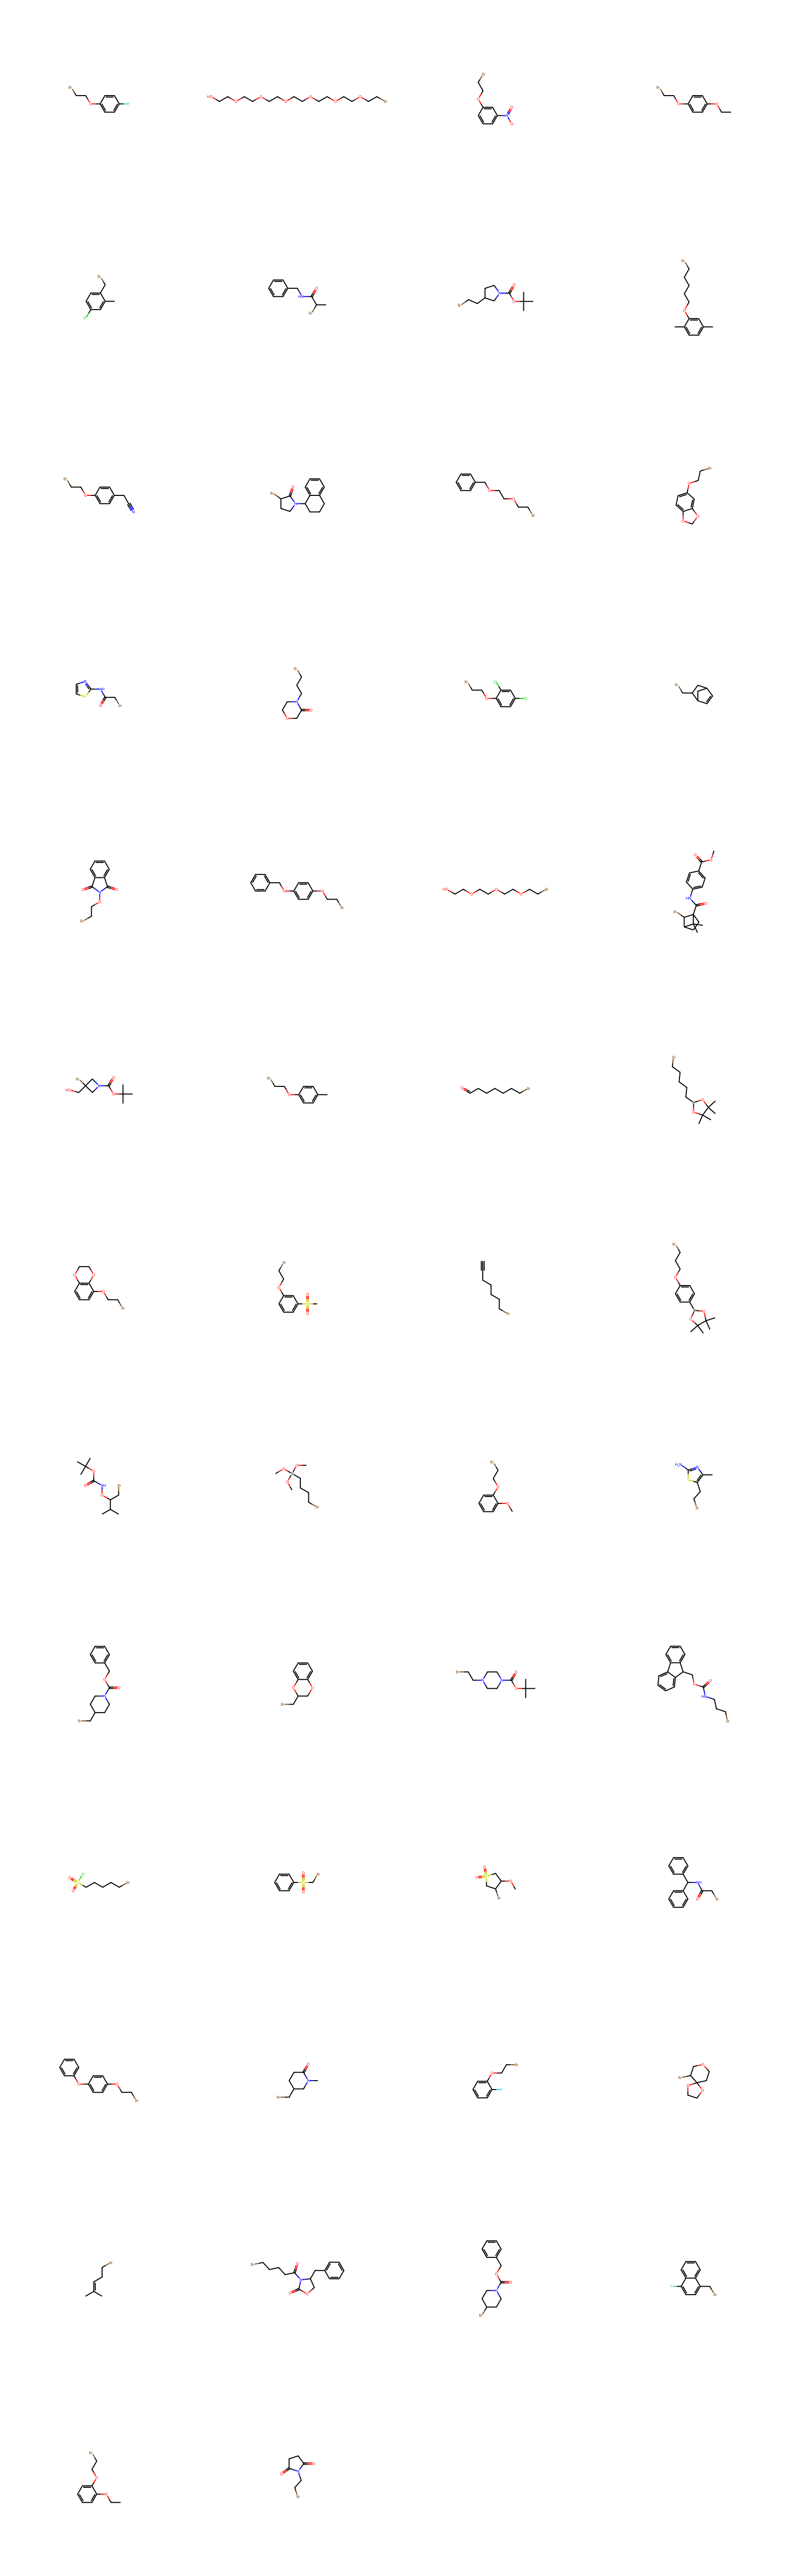

In [26]:
Chem.Draw.MolsToGridImage(df["ROMol"], subImgSize=(400,400), molsPerRow=4)

,ID,ROMol
0,,
1,,
2,,
3,,
4,,
5,,
6,,
7,,
8,,
9,,

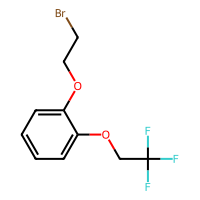
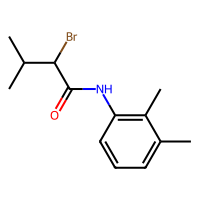
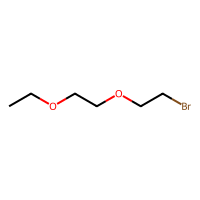
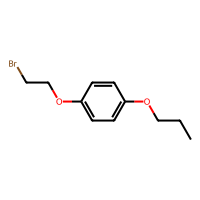
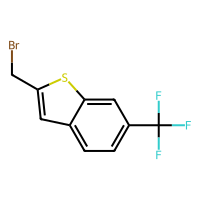
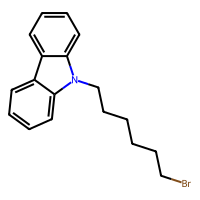
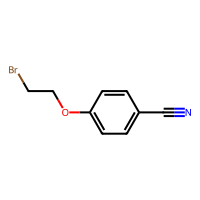
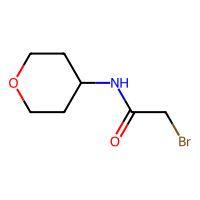
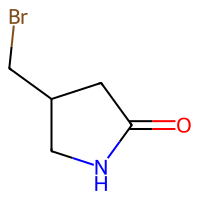
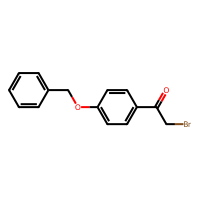
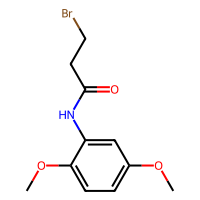
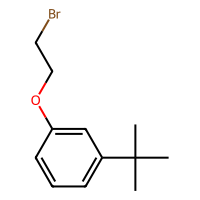
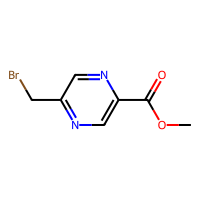
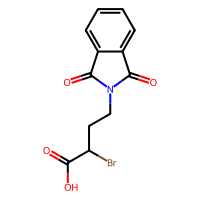
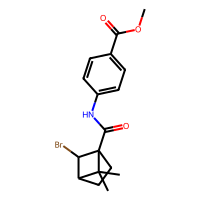
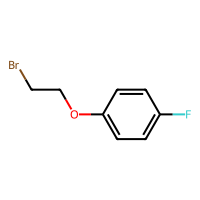

In [36]:
PandasTools.LoadSDF('iterations/batch_2/batch2_selections.sdf')

,ID,ROMol
0,,
1,,
2,,
3,,
4,,
5,,
6,,
7,,
8,,
9,,

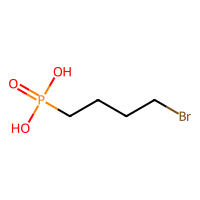
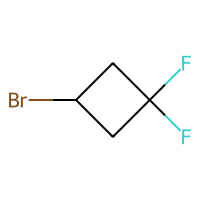
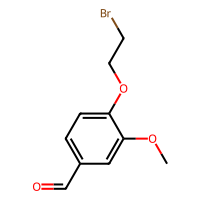
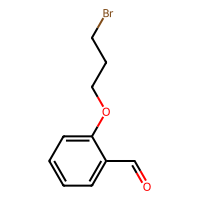
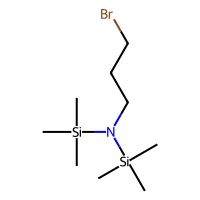
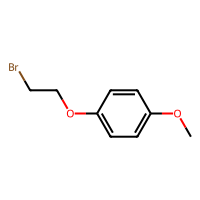
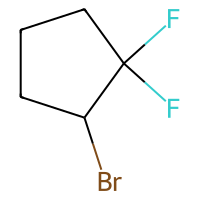
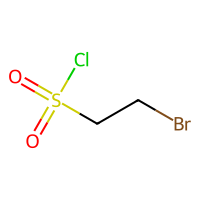
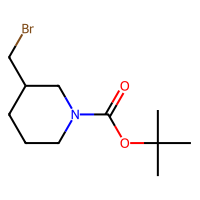
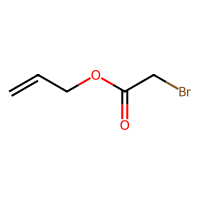
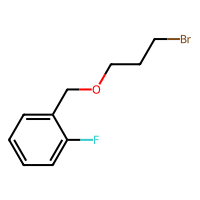
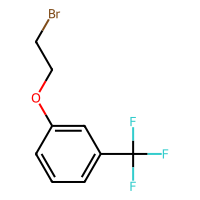

In [40]:
PandasTools.LoadSDF('iterations/batch_1/selections.sdf')

In [41]:
import tarfile

with tarfile.open(f'iterations/batch_3.tar.gz', "w:gz") as tar:
    tar.add("iterations/batch_3/")

In [89]:
# In which DFT features are the bromo-ethers chosen here notably different from each other (or other molecules in the dataset)
prop1 = pd.read_csv("iterations/batch_1/proposed_experiments.csv", index_col=0)
prop2 = pd.read_csv("iterations/batch_2/proposed_experiments.csv", index_col=0)
prop3 = pd.read_csv("iterations/batch_3/proposed_experiments.csv", index_col=0)

prop1.rename(columns={"P1:CAD Yield":"CAD Percent Yield (%)"}, inplace=True)

In [152]:
prop3.iloc[0]["smiles"]

'CC(C)(C)OC(=O)N1CCC(COc2ccc(CCOc3ccc(F)cc3)cc2)CC1'

In [153]:
prop3.iloc[0]["CAD Percent Yield (%)"]

42.95768459388321

In [90]:
prop1["selection"] = "active_learning_1"
prop2["selection"] = "active_learning_2"
prop3["selection"] = "active_learning_3"
proposed = pd.concat([prop1, prop2, prop3])
proposed["smiles"] = proposed['smiles'].apply(lambda x: Chem.CanonSmiles(x, False))

In [91]:
proposed.shape

(352, 44)

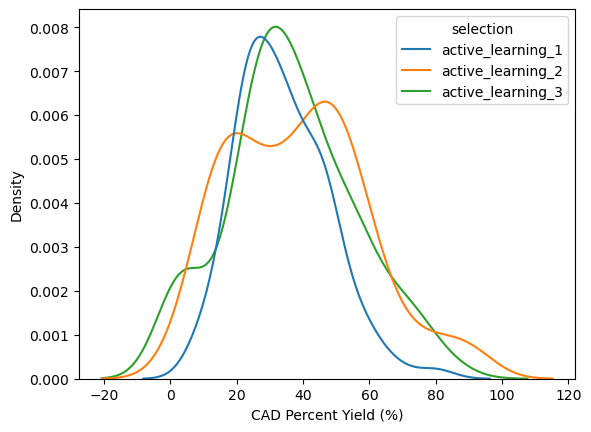

In [121]:
sns.kdeplot(proposed, x="CAD Percent Yield (%)", hue="selection")
plt.show()

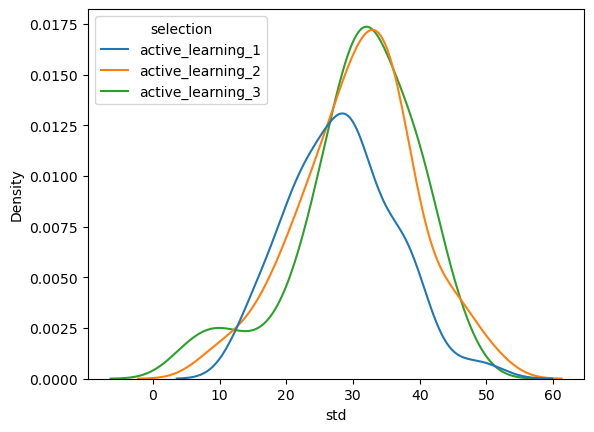

In [122]:
sns.kdeplot(proposed, x="std", hue="selection")
plt.show()

In [101]:
prop_mean = proposed.groupby(["selection", "smiles_alkyl"])[["std", "CAD Percent Yield (%)"]].mean()

In [102]:
prop_mean = prop_mean.reset_index()

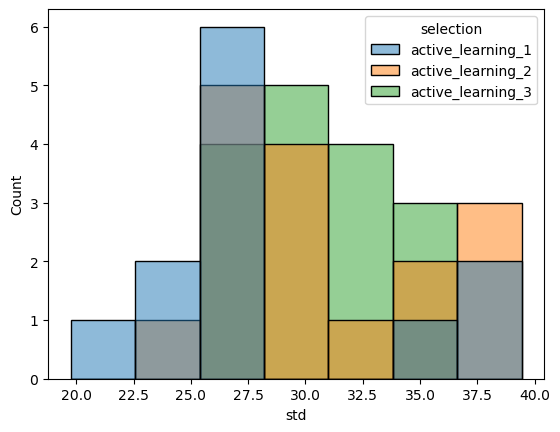

In [103]:
# uncertainty isn't getting lower, just more gaussian. The model may be selecting for molecules with high yield and high noise at this point
sns.histplot(prop_mean, x="std", hue="selection")
plt.show()

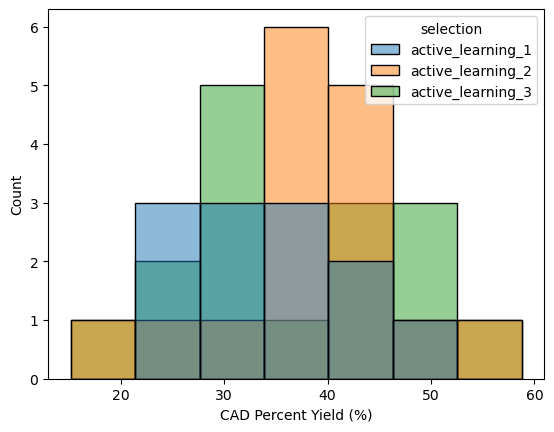

In [104]:
sns.histplot(prop_mean, x="CAD Percent Yield (%)", hue="selection")
plt.show()

In [ ]:
# are the predictions getting better with each iteration? We should have data for prop1 vs results["selection"] == active_learning_1 and 2

In [97]:
results_pred = results.merge(proposed[["smiles", "CAD Percent Yield (%)", "std"]], on="smiles", how="inner", suffixes=["", "_pred"])

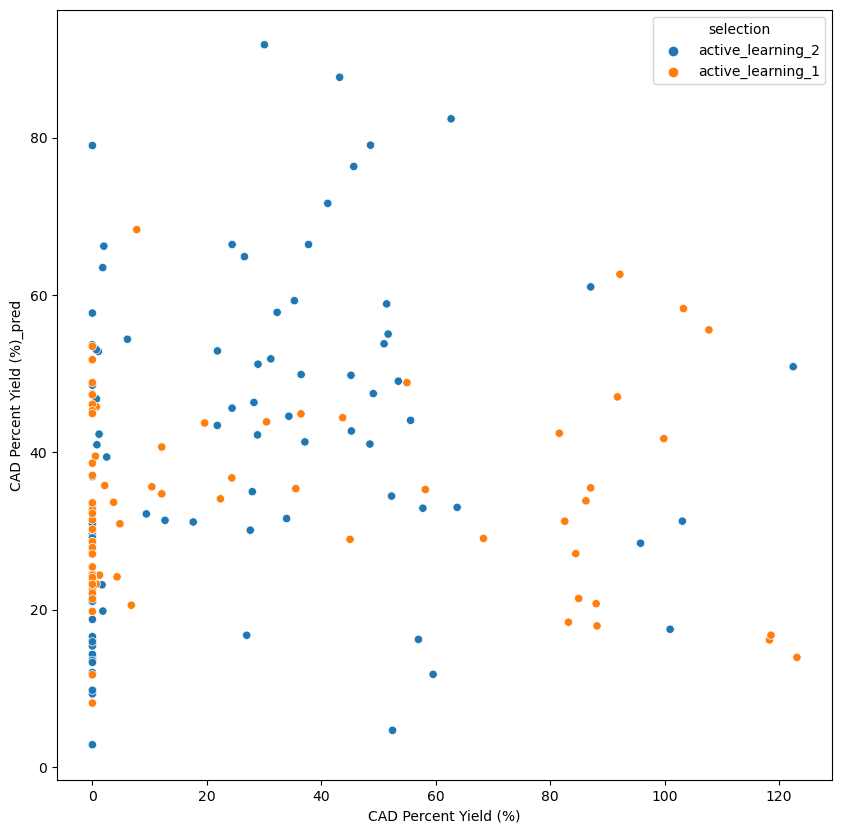

In [126]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=results_pred, x="CAD Percent Yield (%)", y="CAD Percent Yield (%)_pred", hue="selection")
plt.show()

In [106]:
results_pred_1 = results_pred[results_pred["selection"] == "active_learning_1"]
results_pred_2 = results_pred[results_pred["selection"] == "active_learning_2"]
exp_col = "CAD Percent Yield (%)"
pred_col = "CAD Percent Yield (%)_pred"
print(metrics.r2_score(results_pred_1[exp_col], results_pred_1[pred_col]))
print(metrics.r2_score(results_pred_2[exp_col], results_pred_2[pred_col]))

-0.08345451213518262
-0.36064514469027364


In [111]:
print(results_pred_1["CAD Percent Yield (%)"].describe())
print(results_pred_2["CAD Percent Yield (%)"].describe())

count     76.000000
mean      27.997607
std       39.790215
min        0.000000
25%        0.000000
50%        0.968861
75%       55.777497
max      123.138587
Name: CAD Percent Yield (%), dtype: float64
count     96.000000
mean      22.928502
std       28.156858
min        0.000000
25%        0.000000
50%        7.775227
75%       41.657390
max      122.485505
Name: CAD Percent Yield (%), dtype: float64


In [123]:
results_pred_1.groupby("smiles_aryl")[["CAD Percent Yield (%)", "CAD Percent Yield (%)_pred"]].mean()

,CAD Percent Yield (%),CAD Percent Yield (%)_pred
smiles_aryl,,
CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,45.651241,30.913984
CC(C)(C)OC(=O)N1CCN(c2ccc(Br)cc2Cl)CC1,30.645891,39.742050
CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,2.486667,29.650082
COC(=O)c1cc(Br)ccc1OC(F)F,15.547381,37.315804
CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,10.411687,21.760550
Cc1cccc(-c2c(F)cccc2Br)c1,30.856038,37.179708
Cc1nc(-c2ccc(Br)cc2)cs1,41.736017,37.268933
O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,44.223684,29.419876


In [124]:
results_pred_2.groupby("smiles_aryl")[["CAD Percent Yield (%)", "CAD Percent Yield (%)_pred"]].mean()


,CAD Percent Yield (%),CAD Percent Yield (%)_pred
smiles_aryl,,
CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,18.034493,44.359272
CC(C)(C)OC(=O)N1CCN(c2ccc(Br)cc2Cl)CC1,22.706554,46.022524
CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,0.000000,14.332716
COC(=O)c1cc(Br)ccc1OC(F)F,25.989522,31.003094
CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,41.615299,19.915933
Cc1cccc(-c2c(F)cccc2Br)c1,15.772500,44.572730
Cc1nc(-c2ccc(Br)cc2)cs1,31.197327,52.424735
O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,28.112321,49.748304


In [114]:
# IIRC there's a dud core. Has the model figured out nothing is ever going to work for this core?
results_pred.groupby("smiles_aryl")[["CAD Percent Yield (%)", "CAD Percent Yield (%)_pred"]].mean()

,CAD Percent Yield (%),CAD Percent Yield (%)_pred
smiles_aryl,,
CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,30.587560,38.247777
CC(C)(C)OC(=O)N1CCN(c2ccc(Br)cc2Cl)CC1,26.109127,43.330892
CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,1.065714,20.897301
COC(=O)c1cc(Br)ccc1OC(F)F,21.243094,33.872508
CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,28.242322,20.706484
Cc1cccc(-c2c(F)cccc2Br)c1,22.628654,41.212265
Cc1nc(-c2ccc(Br)cc2)cs1,35.987641,45.535734
O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,35.017191,41.036120


In [115]:
prop3.groupby("smiles_aryl")[["CAD Percent Yield (%)"]].mean()

,CAD Percent Yield (%)
smiles_aryl,
CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,37.517592
CC(C)(C)OC(=O)N1CCN(c2ccc(Br)cc2Cl)CC1,44.553648
CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,5.369302
COC(=O)c1cc(Br)ccc1OC(F)F,34.777490
CS(=O)(=O)N(c1ccc(Br)cc1)S(C)(=O)=O,35.905804
Cc1cccc(-c2c(F)cccc2Br)c1,33.079476
Cc1nc(-c2ccc(Br)cc2)cs1,49.994394
O=S(=O)(c1ccc(Br)cc1)N1CCSCC1,49.887242


In [116]:
# how well does the active learning model perform on the random set data that Lucas collected? A lot of those molecules were not reactive
exp_rand1 = pd.read_excel("data/SOUZALUH-100-EXP013_Yields_final_random1.xlsx")

In [117]:
exp_rand1["CAD Percent Yield (%)"].describe()

count    95.000000
mean      6.351829
std      15.269624
min       0.000000
25%       0.000000
50%       0.000000
75%       2.799287
max      78.383544
Name: CAD Percent Yield (%), dtype: float64

In [48]:
alkyl_exp = alkyl.loc[list(results["smiles_alkyl"].unique())]
alkyl_exp

,tm_freeh_HOMO(eV),tm_freeh_LUMO(eV),tm_freeh_HLgap(eV),tm_freeh_HOMO(eV)_alk,tm_freeh_LUMO(eV)_alk,tm_freeh_HLgap(eV)_alk,tm_freeh_HOMO(eV)_rad,tm_freeh_LUMO(eV)_rad,tm_freeh_HLgap(eV)_rad,rad_br,...,Br_tm_water_nucleophilic_paboon,Br_tm_water_nucleophilic_fasm,Br_tm_water_electrophilic_mulliken,Br_tm_water_electrophilic_loewdin,Br_tm_water_electrophilic_paboon,Br_tm_water_electrophilic_fasm,Br_tm_water_radical_mulliken,Br_tm_water_radical_loewdin,Br_tm_water_radical_paboon,Br_tm_water_radical_fasm
smiles,,,,,,,,,,,,,,,,,,,,,
O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1,-8.69393,-0.16277,8.53116,-8.55647,0.56444,9.12090,-7.72252,-1.28813,6.43439,0.024041,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
CC(C)(C)OC(=O)N1CCCC(CBr)C1,-8.70383,1.80663,10.51046,-8.48650,3.15677,11.64327,-7.84647,0.55491,8.40138,0.047924,...,0.2859,0.3502,0.1213,0.1143,0.1175,0.1224,0.2442,0.2313,0.2017,0.2363
COc1ccc2c(CBr)cc(=O)oc2c1,-8.23929,-0.53271,7.70659,-8.06036,0.00414,8.06451,-8.02587,-1.51615,6.50973,0.022402,...,0.1342,0.1708,0.0558,0.0492,0.0497,0.0694,0.1056,0.0998,0.0919,0.1201
COc1cc(C=O)ccc1OCCBr,-8.13774,0.14331,8.28105,-7.91786,0.31024,8.22810,-7.96162,0.16890,8.13052,0.046255,...,0.0120,0.0178,0.0286,0.0248,0.0246,0.0331,0.0215,0.0184,0.0183,0.0254
FC(F)(F)c1cccc(OCCBr)c1,-8.79204,0.65513,9.44717,-8.49642,0.87998,9.37640,-8.40660,-0.08439,8.32221,0.044488,...,0.0721,0.1195,0.1329,0.1235,0.1264,0.1328,0.1231,0.1148,0.0992,0.1262
OB(O)c1ccc(OCCBr)cc1,-8.33521,1.13982,9.47503,-8.04392,1.38359,9.42751,-8.06275,0.12281,8.18556,0.045214,...,0.1021,0.1553,0.0931,0.0844,0.0860,0.0951,0.1213,0.1130,0.0940,0.1252
C[Si](C)(C)N(CCCBr)[Si](C)(C)C,-8.17276,1.93010,10.10286,-8.03176,3.06496,11.09672,-7.68825,0.72295,8.41119,0.047474,...,0.3193,0.4215,0.0764,0.0722,0.0715,0.0898,0.2477,0.2350,0.1954,0.2557
COc1ccc(F)cc1C(=O)CBr,-8.52986,-0.35718,8.17268,-8.40537,0.08859,8.49396,-8.34341,-1.37797,6.96543,0.031352,...,0.1207,0.1668,0.1010,0.0933,0.0947,0.1192,0.1225,0.1162,0.1077,0.1430
Cc1nc(C)c2c(n1)OC(CBr)C2,-8.84415,0.93592,9.78007,-8.59383,1.13863,9.73246,-8.41609,-0.11083,8.30525,0.047594,...,0.0715,0.1181,0.1132,0.1064,0.1083,0.1164,0.1105,0.1051,0.0899,0.1173


In [46]:
# which features in alkyl are farthest from the experimental data (relative to mean and std)
alkyl_sel = alkyl.loc[list(prop["smiles_alkyl"].unique())]
alkyl_sel

,tm_freeh_HOMO(eV),tm_freeh_LUMO(eV),tm_freeh_HLgap(eV),tm_freeh_HOMO(eV)_alk,tm_freeh_LUMO(eV)_alk,tm_freeh_HLgap(eV)_alk,tm_freeh_HOMO(eV)_rad,tm_freeh_LUMO(eV)_rad,tm_freeh_HLgap(eV)_rad,rad_br,...,Br_tm_water_nucleophilic_paboon,Br_tm_water_nucleophilic_fasm,Br_tm_water_electrophilic_mulliken,Br_tm_water_electrophilic_loewdin,Br_tm_water_electrophilic_paboon,Br_tm_water_electrophilic_fasm,Br_tm_water_radical_mulliken,Br_tm_water_radical_loewdin,Br_tm_water_radical_paboon,Br_tm_water_radical_fasm
smiles,,,,,,,,,,,,,,,,,,,,,
FC(F)(F)COc1ccccc1OCCBr,-8.31276,1.40957,9.72233,-8.14706,1.58089,9.72795,-8.19745,0.09095,8.28841,0.045427,...,0.1359,0.2020,0.0594,0.0541,0.0536,0.0794,0.1258,0.1206,0.0948,0.1407
Cc1cccc(NC(=O)C(Br)C(C)C)c1C,-8.09330,1.15436,9.24766,-7.94954,1.39116,9.34071,-7.64566,-0.97021,6.67546,0.035022,...,0.0877,0.1288,0.0517,0.0428,0.0394,0.0646,0.0870,0.0761,0.0635,0.0967
CCOCCOCCBr,-9.22642,2.28009,11.50651,-8.89372,3.56323,12.45695,-7.92362,0.52941,8.45303,0.049329,...,0.3724,0.4653,0.1916,0.1805,0.1840,0.1976,0.3302,0.3166,0.2782,0.3315
CCCOc1ccc(OCCBr)cc1,-7.63854,1.40021,9.03875,-7.37055,1.65468,9.02524,-7.39145,0.24844,7.63989,0.045610,...,0.1344,0.1986,0.0481,0.0404,0.0402,0.0524,0.1197,0.1116,0.0873,0.1255
FC(F)(F)c1ccc2cc(CBr)sc2c1,-8.57646,-0.33367,8.24279,-8.30652,0.33462,8.64114,-7.40276,-1.36268,6.04008,0.017751,...,0.1548,0.1938,0.0922,0.0856,0.0870,0.1038,0.1375,0.1329,0.1209,0.1488
BrCCCCCCn1c2ccccc2c2ccccc21,-7.49472,0.73373,8.22845,-7.42479,0.79926,8.22405,-7.44166,0.77921,8.22087,0.047080,...,0.0014,0.0019,0.0025,0.0020,0.0022,0.0038,0.0019,0.0015,0.0018,0.0029
N#Cc1ccc(OCCBr)cc1,-8.77826,0.36266,9.14092,-8.50257,0.59281,9.09538,-8.50688,-0.27166,8.23522,0.044167,...,0.0479,0.0799,0.1173,0.1093,0.1122,0.1170,0.0964,0.0892,0.0800,0.0985
O=C(CBr)NC1CCOCC1,-9.28023,1.65528,10.93551,-8.95619,2.81817,11.77436,-8.85267,-0.98895,7.86372,0.038826,...,0.3242,0.4344,0.1488,0.1426,0.1446,0.1498,0.2789,0.2715,0.2344,0.2921
O=C1CC(CBr)CN1,-9.04838,1.67999,10.72837,-8.77308,2.95653,11.72962,-8.04321,0.31287,8.35609,0.047918,...,0.2921,0.3785,0.2349,0.2318,0.2388,0.2253,0.3048,0.2933,0.2655,0.3019


In [77]:
alkyl_sel["Br_tm_water_nmr_iso"]

smiles
FC(F)(F)COc1ccccc1OCCBr                      2364.809144
Cc1cccc(NC(=O)C(Br)C(C)C)c1C                 2368.187047
CCOCCOCCBr                                   2417.069757
CCCOc1ccc(OCCBr)cc1                          2425.321206
FC(F)(F)c1ccc2cc(CBr)sc2c1                   2063.520823
BrCCCCCCn1c2ccccc2c2ccccc21                  2385.211258
N#Cc1ccc(OCCBr)cc1                           2412.417169
O=C(CBr)NC1CCOCC1                            2380.628133
O=C1CC(CBr)CN1                               2358.828923
O=C(CBr)c1ccc(OCc2ccccc2)cc1                 2446.871387
COc1ccc(OC)c(NC(=O)CCBr)c1                   2366.410174
CC(C)(C)c1cccc(OCCBr)c1                      2424.229163
COC(=O)c1cnc(CBr)cn1                         2114.192723
O=C(O)C(Br)CCN1C(=O)c2ccccc2C1=O             1956.221069
COC(=O)c1ccc(NC(=O)C23CCC(C2Br)C3(C)C)cc1    2357.466692
Fc1ccc(OCCBr)cc1                             2422.789791
Name: Br_tm_water_nmr_iso, dtype: float64

* Calculate mean and standard deviation for each column (from full alkyl dataframe)
* Find minimum difference between each proposed molecule and a value in 

In [49]:
from sklearn import ensemble
from sklearn.inspection import permutation_importance

In [50]:
# RF feature importance
train_X = results[f_cols]
train_y = results[task_name]
train_X

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2125,f_2126,f_2127,f_2128,f_2129,f_2130,f_2131,f_2132,f_2133,f_2134
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1638,0.2128,0.0555,0.0539,0.0546,0.0573,0.1263,0.1238,0.1092,0.1351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647
157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647
158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647
159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.3402,0.4295,0.5569,0.5482,0.5672,0.4998,0.4963,0.4737,0.4537,0.4647


In [51]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=500, random_state=42)
model.fit(train_X, train_y)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

In [52]:
feature_importance = permutation_importance(
    model, train_X, train_y, n_repeats=10, random_state=42, n_jobs=-1
)

In [53]:
feature_importance

{'importances_mean': array([0.00036816, 0.        , 0.00012912, ..., 0.00082797, 0.00417821,
        0.00082788]),
 'importances_std': array([7.13511789e-05, 0.00000000e+00, 2.30155067e-05, ...,
        1.79883253e-04, 9.44788522e-04, 1.89747054e-04]),
 'importances': array([[3.34312851e-04, 3.13693814e-04, 4.96881577e-04, ...,
         3.36943970e-04, 3.23706198e-04, 3.37829681e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.20080654e-04, 1.31142530e-04, 1.70046530e-04, ...,
         8.94706911e-05, 1.16736178e-04, 1.48394408e-04],
        ...,
        [1.02120533e-03, 8.64380410e-04, 8.07244840e-04, ...,
         7.79161056e-04, 6.92230764e-04, 4.99297575e-04],
        [4.68752436e-03, 3.34312640e-03, 2.42346167e-03, ...,
         4.78146080e-03, 4.62907481e-03, 4.73344959e-03],
        [8.14094322e-04, 4.49062823e-04, 7.40372279e-04, ...,
         9.10341977e-04, 7.79161546e-04, 1.04827945e-03]]

In [54]:
fimp_ser = pd.Series(feature_importance.importances_mean, index=f_cols)

In [57]:
fimp_ser.sort_values(ascending=False).head(10)

f_2118    0.751954
f_2053    0.086373
f_1656    0.035553
f_841     0.028968
f_2051    0.014913
f_2048    0.012721
f_2111    0.011610
f_2099    0.010579
f_550     0.009974
f_2057    0.009522
dtype: float64

In [70]:
ar_col = list(aryl.columns)
alk_col = list(alkyl.columns)
print(alk_col[2118 - 2048 - 42])
print(ar_col[2053 - 2048])
print()
print()
print(ar_col[2051 - 2048])
print(ar_col[0])
print(alk_col[2111 - 2048 - 42])
print(alk_col[2099 - 2048 - 42])
print()
print(ar_col[2057 - 2048])

Br_tm_water_nmr_iso
core_tm_freeh_HOMO(eV)


core_tm_water_electronegativity [eV]
core_tm_water_ionization_potential [eV]
C_tm_water_electrophilic_loewdin
rad_br

core_C_tm_water_charge_mulliken


In [71]:
domain["f_2118"]

0        2368.363815
1        2368.363815
2        2368.363815
3        2368.363815
4        2368.363815
            ...     
22203    2530.434365
22204    2530.434365
22205    2530.434365
22206    2530.434365
22207    2530.434365
Name: f_2118, Length: 21624, dtype: float64

In [72]:
alkyl["Br_tm_water_nmr_iso"]

smiles
BrC(c1ccccc1)(c1ccccc1)c1ccccc1     1391.305852
BrC(c1ccccc1)c1ccccc1               1830.429050
BrC(c1ccccc1)c1ccccn1               1866.060290
BrC1(c2ccccc2)c2ccccc2-c2ccccc21    1672.950762
BrC1(c2ccccn2)CC1                   2135.347006
                                       ...     
Oc1ccc2ccc(OCCCCBr)cc2n1            2387.348005
Oc1cccc(CBr)c1                      2115.344031
Oc1cccc(CCBr)c1                     2384.237076
Oc1ccccc1CCBr                       2385.080724
SCCCBr                              2417.363824
Name: Br_tm_water_nmr_iso, Length: 2776, dtype: float64

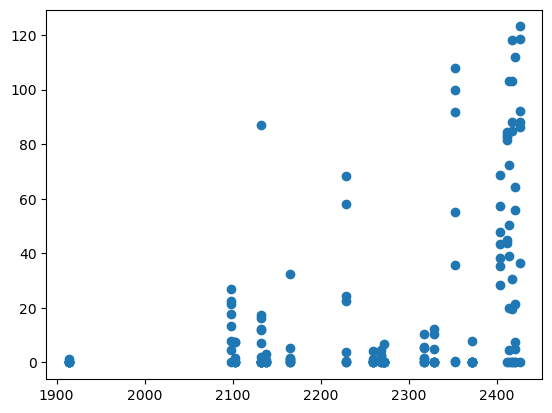

In [74]:
plt.scatter(results["f_2118"], results["CAD Percent Yield (%)"])

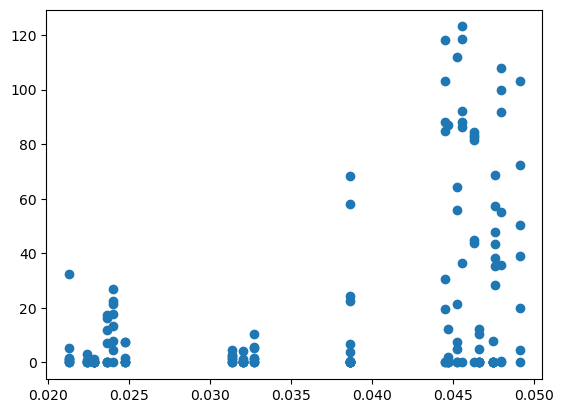

In [75]:
plt.scatter(results["f_2099"], results["CAD Percent Yield (%)"])

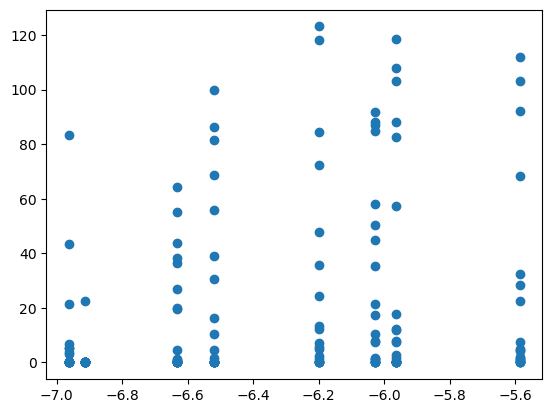

In [76]:
plt.scatter(results["f_2053"], results["CAD Percent Yield (%)"])